### Imports

In [1]:
# ---- STDLIB ----
import os
from glob import glob
import time

# ---- NUMERIC & ML ----
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

# ---- CV / IMAGE PROCESSING ----
import cv2
from skimage.feature import hog

# ---- TENSORFLOW / KERAS ----
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---- VISUALIZATION ----
import matplotlib.pyplot as plt

### Data Processing

In [2]:
DATA_DIR = "GTSRB"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")   
IMG_SIZE = 48
CHANNELS = 3
BATCH_SIZE = 64
RANDOM_STATE = 42

In [3]:
def load_from_folder(root_dir, img_size=IMG_SIZE):
    images = []
    labels = []
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        files = glob(os.path.join(cls_path, "*.*"))
        for f in files:
            img = cv2.imread(f)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(int(cls))
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)


In [4]:
images, labels = load_from_folder(TRAIN_DIR)
print("Loaded:", images.shape, labels.shape)

images = images / 255.0

Loaded: (39209, 48, 48, 3) (39209,)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.15, random_state=RANDOM_STATE, stratify=labels
)

#### Classes encoding

In [6]:
num_classes = len(np.unique(labels))
print("Number of classes:", num_classes)

lb = LabelBinarizer()
lb.fit(np.arange(num_classes))
y_train_ohe = lb.transform(y_train)
y_val_ohe = lb.transform(y_val)

Number of classes: 43


In [7]:
class_names = {
    0: "Speed limit 20 km/h",
    1: "Speed limit 30 km/h",
    2: "Speed limit 50 km/h",
    3: "Speed limit 60 km/h",
    4: "Speed limit 70 km/h",
    5: "Speed limit 80 km/h",
    6: "End of speed limit 80 km/h",
    7: "Speed limit 100 km/h",
    8: "Speed limit 120 km/h",
    9: "No passing",
    10: "No passing for vehicles over 3.5 tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 tons"
}

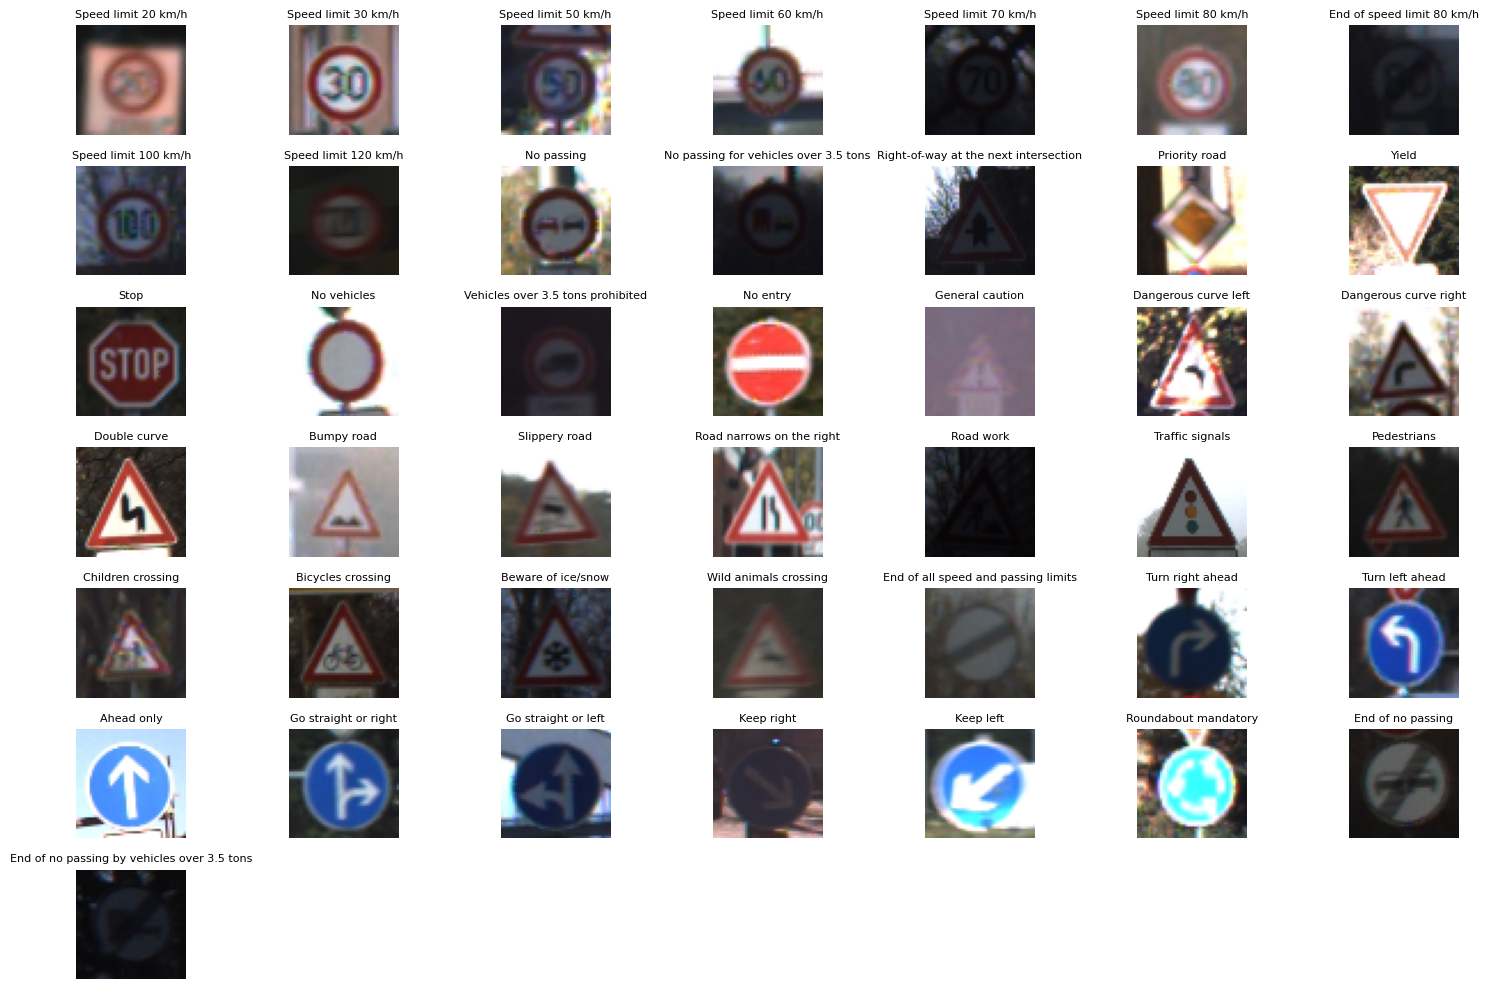

In [8]:
example_per_class = {}
for class_id in range(len(class_names)):
    indices = np.where(y_train == class_id)[0]
    if len(indices) > 0:
        example_per_class[class_id] = X_train[indices[0]]

plt.figure(figsize=(15, 10))
cols = 7
rows = int(np.ceil(len(class_names)/cols))

for i, class_id in enumerate(sorted(example_per_class.keys())):
    plt.subplot(rows, cols, i+1)
    plt.imshow(example_per_class[class_id])
    plt.title(class_names[class_id], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Data augmentation

In [9]:
train_datagen = ImageDataGenerator()  
val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train_ohe, batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val_ohe, batch_size=BATCH_SIZE)

In [10]:
X_batch, y_batch = next(train_gen)

print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

X_val_batch, y_val_batch = next(val_gen)
print("X_val_batch shape:", X_val_batch.shape)
print("y_val_batch shape:", y_val_batch.shape)

X_batch shape: (64, 48, 48, 3)
y_batch shape: (64, 43)
X_val_batch shape: (64, 48, 48, 3)
y_val_batch shape: (64, 43)


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.12,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.08,
    horizontal_flip=False,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train_ohe, batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val_ohe, batch_size=BATCH_SIZE)

In [12]:
X_batch, y_batch = next(train_gen)

print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

X_val_batch, y_val_batch = next(val_gen)
print("X_val_batch shape:", X_val_batch.shape)
print("y_val_batch shape:", y_val_batch.shape)

X_batch shape: (64, 48, 48, 3)
y_batch shape: (64, 43)
X_val_batch shape: (64, 48, 48, 3)
y_val_batch shape: (64, 43)


### Models creation

In [13]:
def make_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

model = make_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,477,963 (5.64 MB)

 Trainable params: 1,477,963 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting model

In [14]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
mc = callbacks.ModelCheckpoint("gtsrb_best.keras", monitor="val_loss", save_best_only=True)

EPOCHS = 10
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[es, mc]
)

Epoch 1/10


c:\Users\lmax1\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


521/521 ━━━━━━━━━━━━━━━━━━━━ 70s 131ms/step - accuracy: 0.0962 - loss: 3.3763 - val_accuracy: 0.5041 - val_loss: 1.5284
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 68s 131ms/step - accuracy: 0.4909 - loss: 1.6007 - val_accuracy: 0.9145 - val_loss: 0.2987
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 69s 133ms/step - accuracy: 0.8055 - loss: 0.6057 - val_accuracy: 0.9765 - val_loss: 0.0909
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 73s 139ms/step - accuracy: 0.8955 - loss: 0.3253 - val_accuracy: 0.9844 - val_loss: 0.0577
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 69s 132ms/step - accuracy: 0.9306 - loss: 0.2171 - val_accuracy: 0.9937 - val_loss: 0.0233
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 68s 131ms/step - accuracy: 0.9500 - loss: 0.1635 - val_accuracy: 0.9946 - val_loss: 0.0185
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 68s 130ms/step - accuracy: 0.9581 - loss: 0.1361 - val_accuracy: 0.9959 - val_loss: 0.0119
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 69s 132ms/step - accuracy: 0.9661 - loss: 0.1134 - val

### Results 

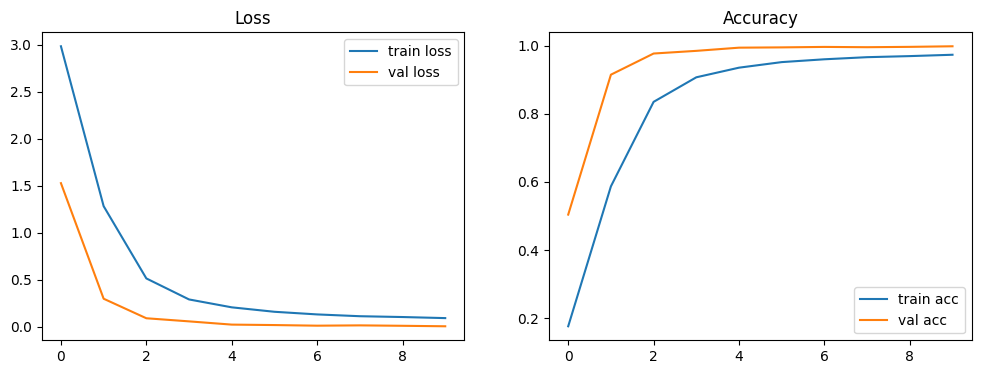

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9967 - loss: 0.0072
Validation loss: 0.0055, accuracy: 0.9978


In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy")
plt.show()

val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


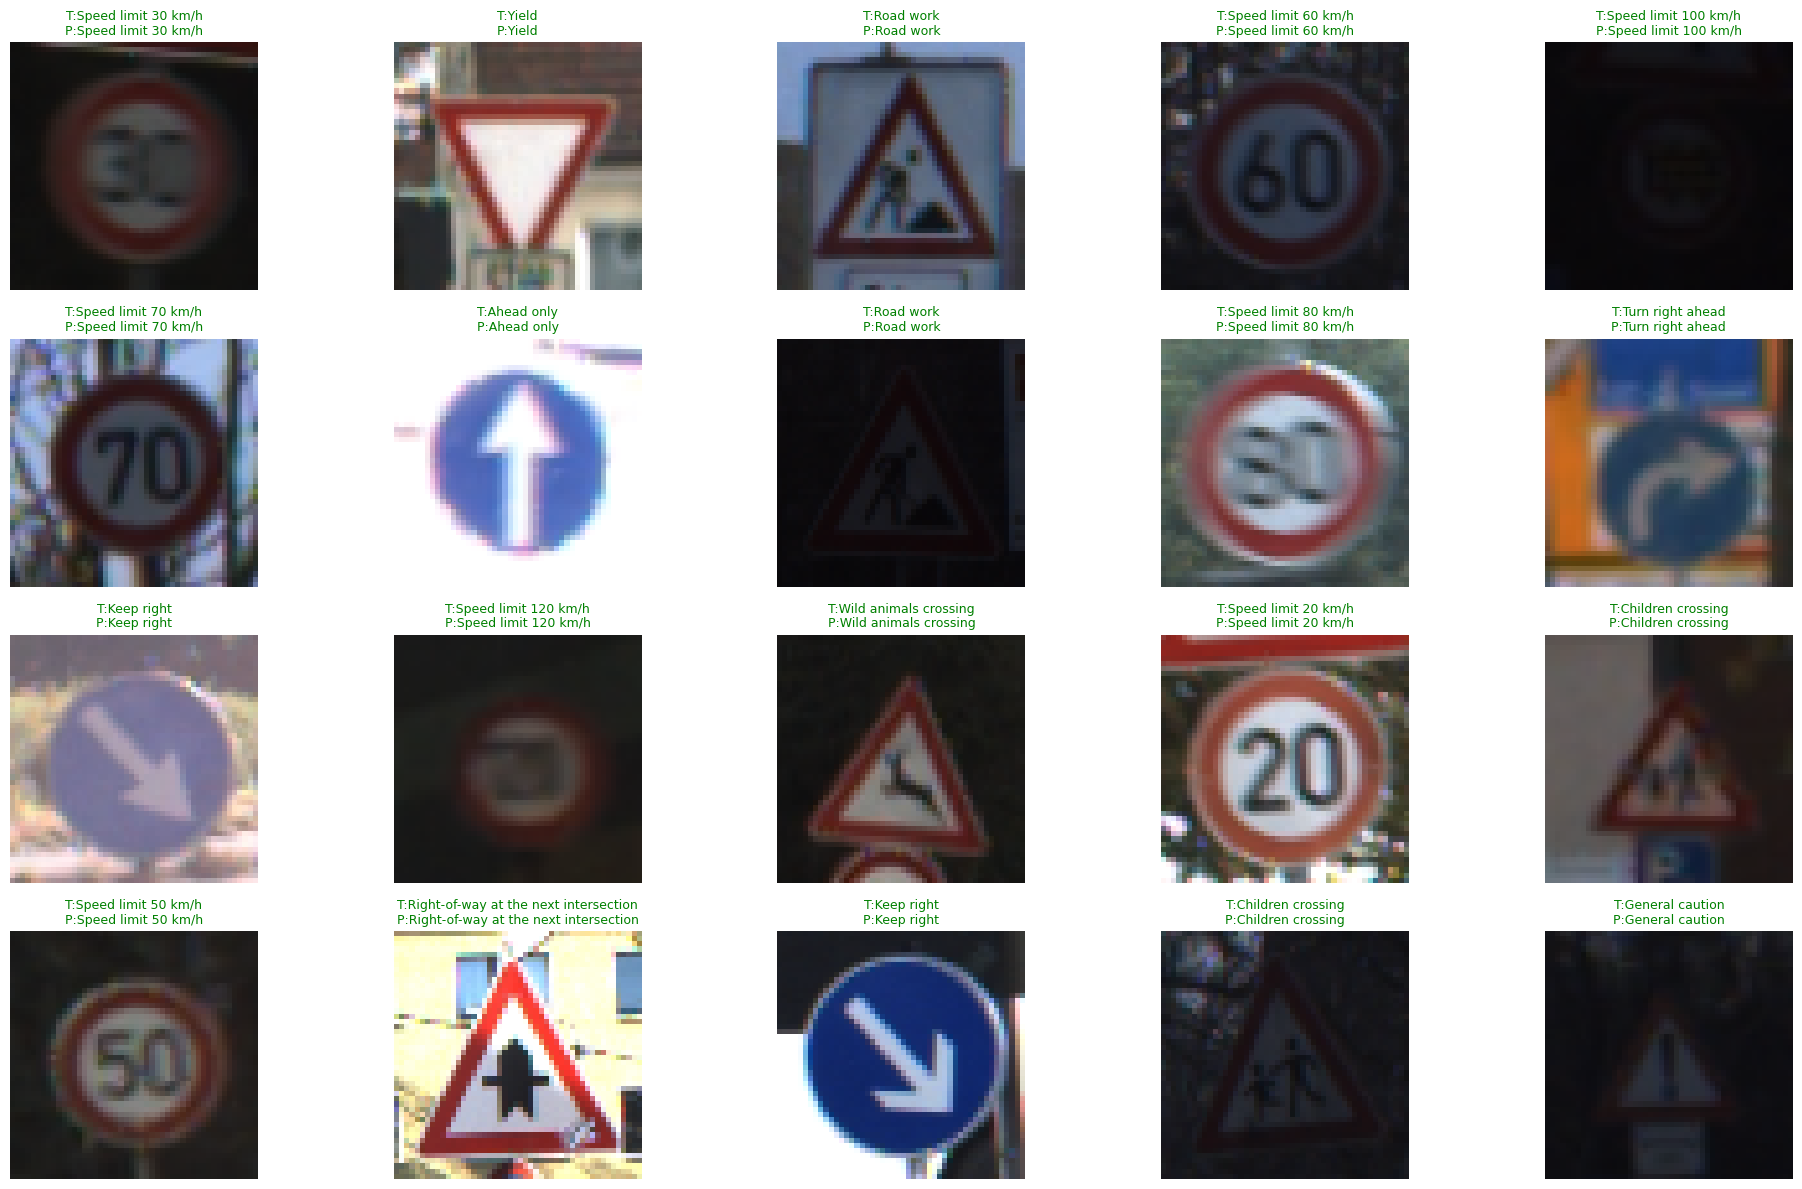

In [16]:
y_pred_prob = model.predict(X_val, batch_size=256)
y_pred = np.argmax(y_pred_prob, axis=1)

y_pred_names = [class_names[i] for i in y_pred]
y_true_names = [class_names[i] for i in y_val]

def show_samples_grid_names(X, y_true_names, y_pred_names, n=20, per_row=5):
    import math
    idxs = np.random.choice(len(X), n, replace=False)
    rows = math.ceil(n / per_row)
    plt.figure(figsize=(per_row*4, rows*3))
    
    for i, idx in enumerate(idxs):
        plt.subplot(rows, per_row, i+1)
        plt.imshow(X[idx])
        plt.axis("off")
        color = "green" if y_true_names[idx] == y_pred_names[idx] else "red"
        plt.title(f"T:{y_true_names[idx]}\nP:{y_pred_names[idx]}", fontsize=9, color=color)
    
    plt.tight_layout()
    plt.show()

show_samples_grid_names(X_val, y_true_names, y_pred_names, n=20, per_row=5)

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)

Validation Accuracy: 0.9977898673920436


In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=[class_names[i] for i in range(len(class_names))]))

                                             precision    recall  f1-score   support

                        Speed limit 20 km/h       1.00      0.97      0.98        31
                        Speed limit 30 km/h       1.00      0.99      0.99       333
                        Speed limit 50 km/h       1.00      0.99      1.00       338
                        Speed limit 60 km/h       1.00      1.00      1.00       212
                        Speed limit 70 km/h       0.99      1.00      1.00       297
                        Speed limit 80 km/h       1.00      1.00      1.00       279
                 End of speed limit 80 km/h       1.00      1.00      1.00        63
                       Speed limit 100 km/h       1.00      1.00      1.00       216
                       Speed limit 120 km/h       1.00      1.00      1.00       212
                                 No passing       1.00      1.00      1.00       221
      No passing for vehicles over 3.5 tons       1.00      1.00

In [19]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_val, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.99770607503126


In [20]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

top3 = top_k_categorical_accuracy(tf.keras.utils.to_categorical(y_val, num_classes=num_classes),
                                  y_pred_prob, k=3)
print("Top-3 Accuracy:", np.mean(top3))

Top-3 Accuracy: 0.99983


In [21]:
model.save("gtsrb_cnn.keras")

In [23]:
def preprocess_image(img_path, img_size=48):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Cannot read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  
    return img

def predict_image(img_path):
    img = preprocess_image(img_path)
    pred_prob = model.predict(img)
    pred_class = np.argmax(pred_prob, axis=1)[0]
    class_name = class_names[pred_class]
    confidence = pred_prob[0][pred_class]
    return pred_class, class_name, confidence


# img_path = "my_sign.jpg" 
# pred_class, class_name, confidence = predict_image(img_path)
# print(f"Predicted class ID: {pred_class}")
# print(f"Predicted class name: {class_name}")
# print(f"Confidence: {confidence:.3f}")

### Hybrid approach

In [26]:
class_names = {
    0: "Speed limit 20 km/h", 
    1: "Speed limit 30 km/h", 
    2: "Speed limit 50 km/h",
    3: "Speed limit 60 km/h", 
    4: "Speed limit 70 km/h", 
    5: "Speed limit 80 km/h",
    6: "End of speed limit 80 km/h", 
    7: "Speed limit 100 km/h", 
    8: "Speed limit 120 km/h",
    9: "No passing", 
    10: "No passing for vehicles over 3.5 tons", 
    11: "Right-of-way",
    12: "Priority road", 
    13: "Yield", 
    14: "Stop", 
    15: "No vehicles",
    16: "Vehicles >3.5 tons prohibited", 
    17: "No entry", 
    18: "General caution",
    19: "Dangerous curve left", 
    20: "Dangerous curve right", 
    21: "Double curve",
    22: "Bumpy road", 
    23: "Slippery road", 
    24: "Road narrows right",
    25: "Road work", 
    26: "Traffic signals", 
    27: "Pedestrians", 
    28: "Children crossing",
    29: "Bicycles crossing", 
    30: "Ice / Snow", 
    31: "Wild animals",
    32: "End of all restrictions", 
    33: "Turn right ahead", 
    34: "Turn left ahead",
    35: "Ahead only", 
    36: "Go straight or right", 
    37: "Go straight or left",
    38: "Keep right", 
    39: "Keep left", 
    40: "Roundabout",
    41: "End no passing", 
    42: "End no passing trucks"
}


model = tf.keras.models.load_model("gtsrb_cnn.keras")

In [30]:


# ------------------- COLOR MASKING -------------------
def color_mask_hsv(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])

    lower_blue = np.array([100, 120, 50])
    upper_blue = np.array([130, 255, 200])

    mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    return cv2.bitwise_or(mask_red, mask_blue)

# ------------------- MORPHOLOGY -------------------
def morphological_processing(mask):
    kernel = np.ones((1, 1), np.uint8) # (5, 5)
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# ------------------- ROI DETECTION -------------------
def find_candidate_rois(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 500:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        if 0.6 < aspect_ratio < 1.4:
            rois.append((x, y, w, h, img[y:y+h, x:x+w]))
    return rois

# ------------------- HOG FEATURES -------------------
def compute_hog(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (32, 32))  
    return hog(
        resized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        visualize=False
    )

# ------------------- GTSRB REFERENCE -------------------
def build_gtsrb_reference(train_dir):
    ref_features = []
    for class_dir in sorted(os.listdir(train_dir)):
        class_path = os.path.join(train_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        img_paths = glob(os.path.join(class_path, "*.ppm"))
        for img_path in img_paths[:20]:  
            img = cv2.imread(img_path)
            if img is not None:
                ref_features.append(compute_hog(img))
    ref_features = np.array(ref_features)
    print(f"Loaded {len(ref_features)} reference sign samples from GTSRB")
    return ref_features

# ------------------- HOG FILTER -------------------
def is_sign_like(roi, ref_features, threshold=0.25):
    if len(ref_features) == 0:
        return True
    f = compute_hog(roi)
    sims = cosine_similarity([f], ref_features)
    print(sims, np.max(sims), np.max(sims) >= threshold)
    return np.max(sims) >= threshold

def classify_cnn(roi):
    resized = cv2.resize(roi, (48, 48))
    resized = resized.astype("float32") / 255.0
    resized = np.expand_dims(resized, axis=0)

    pred = model.predict(resized, verbose=0)
    class_id = int(np.argmax(pred))
    conf = float(pred[0][class_id])
    return class_id, conf

def process_folder(folder_path, ref_features, cnn_input_size=(48, 48), conf_threshold=0.63):
    image_paths = sorted(glob(os.path.join(folder_path, "*.*")))
    print(f"Processing {len(image_paths)} images from {folder_path}")

    for img_path in image_paths:
        img = cv2.imread(img_path)
        start_time = time.time()

        if img is None:
            continue

        mask = color_mask_hsv(img)
        proc = morphological_processing(mask)
        rois = find_candidate_rois(img, proc)

        detected = []

        for (x, y, w, h, roi) in rois:

            if not is_sign_like(roi, ref_features):
                continue

            # roi_rgb_show = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            # plt.figure(figsize=(2, 2))
            # plt.imshow(roi_rgb_show)
            # plt.title("ROI Before CNN")
            # plt.axis("off")
            # plt.show()

            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(roi_rgb, cnn_input_size)
            resized = resized.astype("float32") / 255.0
            resized = np.expand_dims(resized, axis=0)

            pred = model.predict(resized)
            class_id = int(np.argmax(pred))
            conf = float(pred[0][class_id])

            print(f"CNN - {class_names[class_id]}  (conf={conf:.2f})")

            if conf >= conf_threshold:
                detected.append((x, y, w, h, class_id, conf))

        print("--- %s seconds ---" % (time.time() - start_time))
        vis = img.copy()
        for (x, y, w, h, class_id, conf) in detected:
            cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
            label = f"{class_names[class_id]} ({conf:.2f})"
            cv2.putText(vis, label, (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # fig, axs = plt.subplots(1, 4, figsize=(16, 5))
        # axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # axs[0].set_title("Original")
        # axs[1].imshow(mask, cmap="gray")
        # axs[1].set_title("Color Mask")
        # axs[2].imshow(proc, cmap="gray")
        # axs[2].set_title("After Morphology")
        # axs[3].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        # axs[3].set_title(f"Detected: {len(detected)}")

        # for a in axs:
        #     a.axis("off")

        # plt.tight_layout()
        # plt.show()

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

        axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title("Original")

        axs[0, 1].imshow(mask, cmap="gray")
        axs[0, 1].set_title("Color Mask")

        axs[1, 0].imshow(proc, cmap="gray")
        axs[1, 0].set_title("After Morphology")

        axs[1, 1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        axs[1, 1].set_title(f"Detected: {len(detected)}")

        for a in axs.flatten():
            a.axis("off")

        plt.tight_layout()
        plt.show()

Loaded 0 reference sign samples from GTSRB
Processing 5 images from images_real_maps
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
CNN - Yield  (conf=0.54)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN - Yield  (conf=1.00)
--- 0.2517833709716797 seconds ---


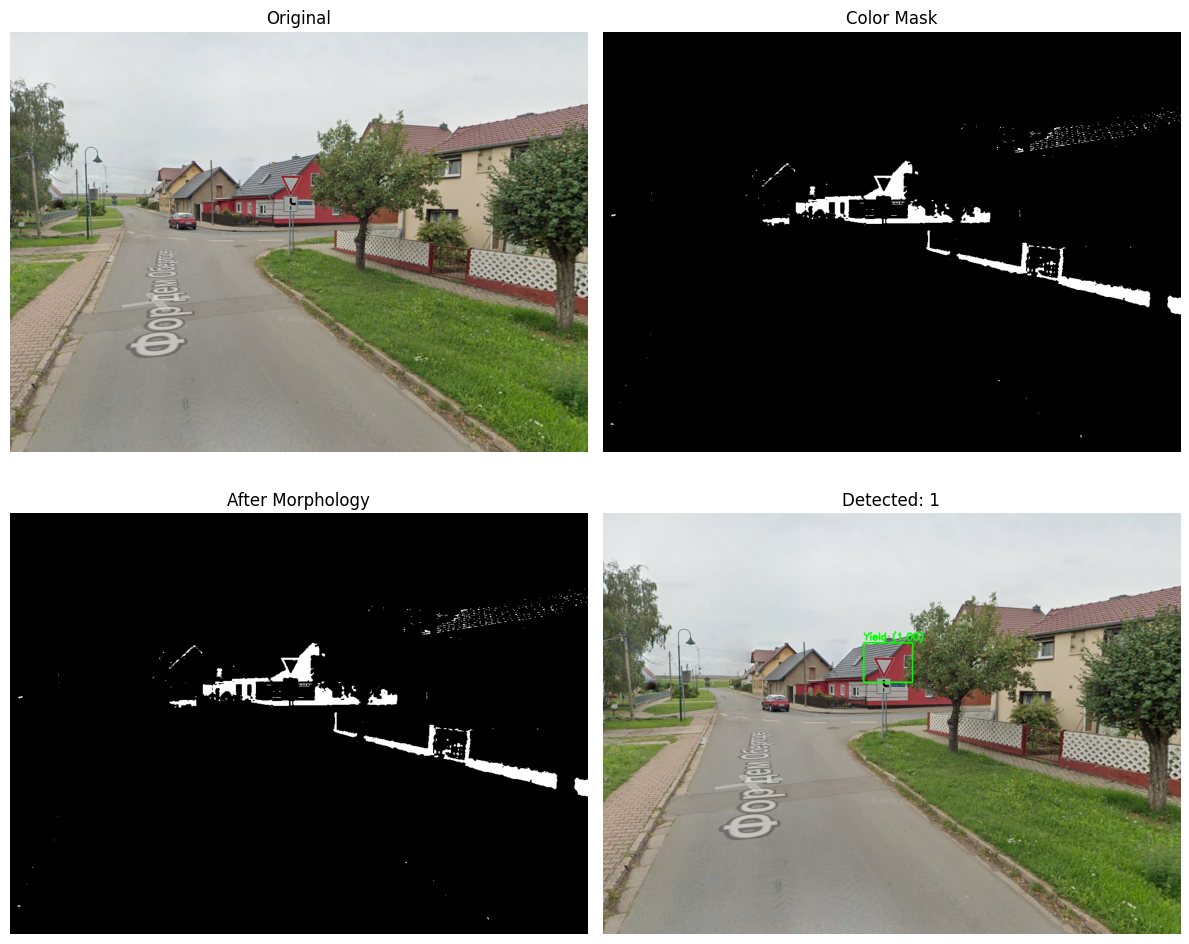

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN - Speed limit 30 km/h  (conf=1.00)
--- 0.07985210418701172 seconds ---


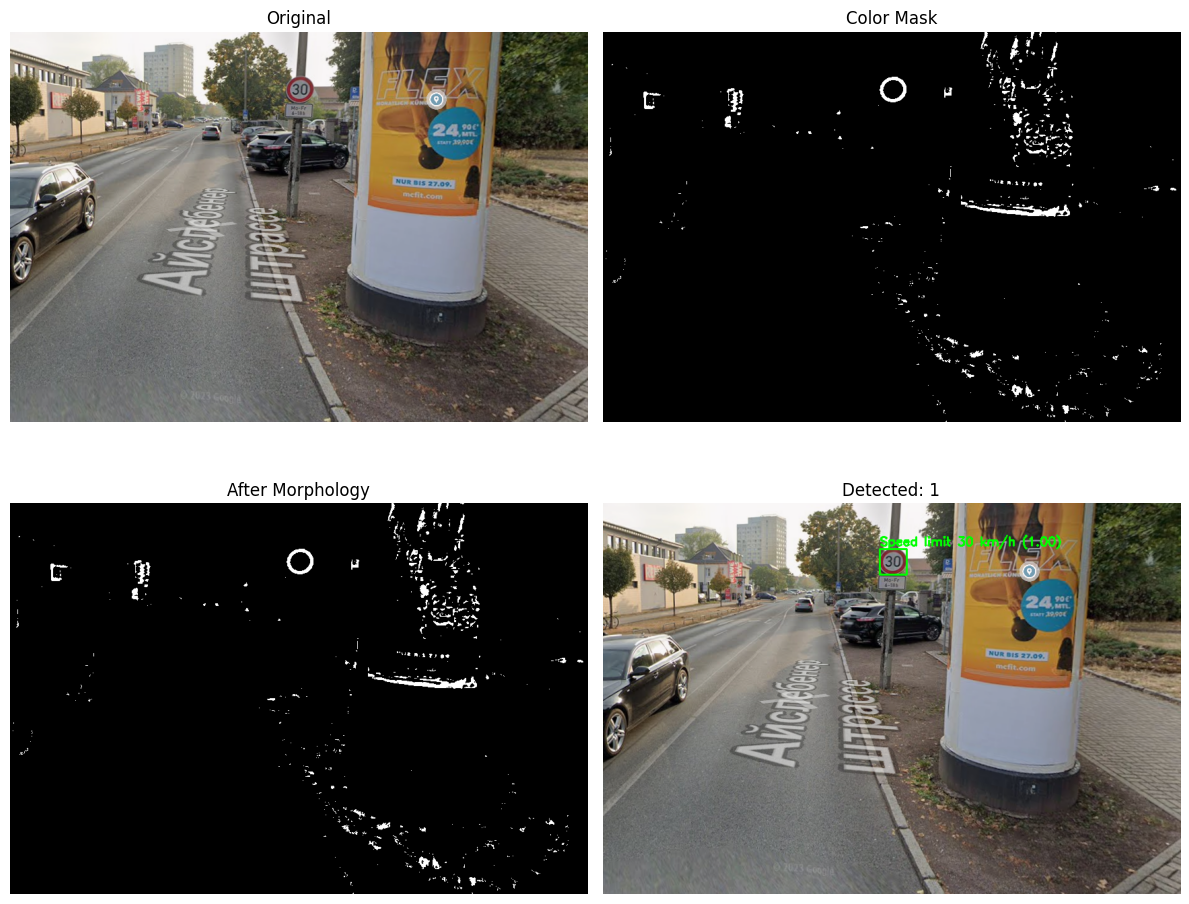

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN - Keep right  (conf=1.00)
--- 0.07830667495727539 seconds ---


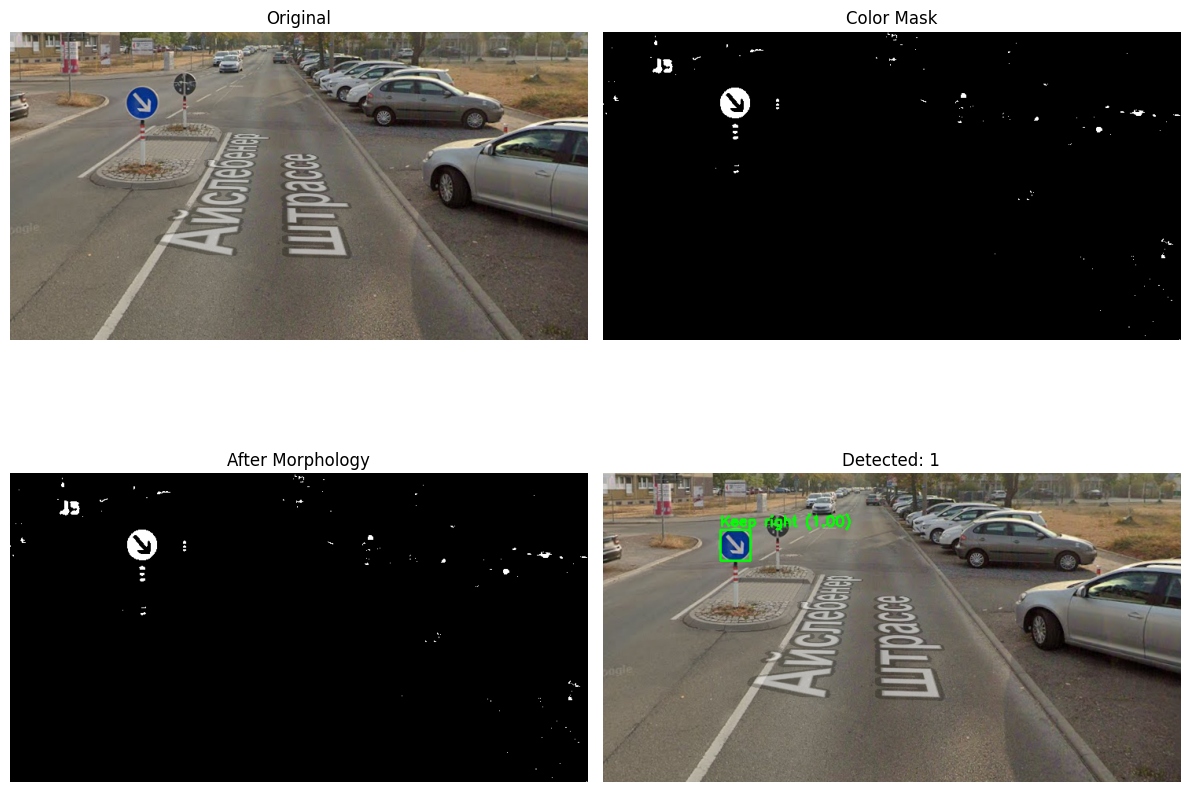

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN - Stop  (conf=0.85)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
CNN - Bicycles crossing  (conf=0.95)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
CNN - Bicycles crossing  (conf=0.98)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN - Speed limit 30 km/h  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
CNN - Ahead only  (conf=0.41)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
CNN - Children crossing  (conf=0.92)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
CNN - Speed limit 30 km/h  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
CNN - Children crossing  (conf=1.00)
--- 0.5730454921722412 seconds ---


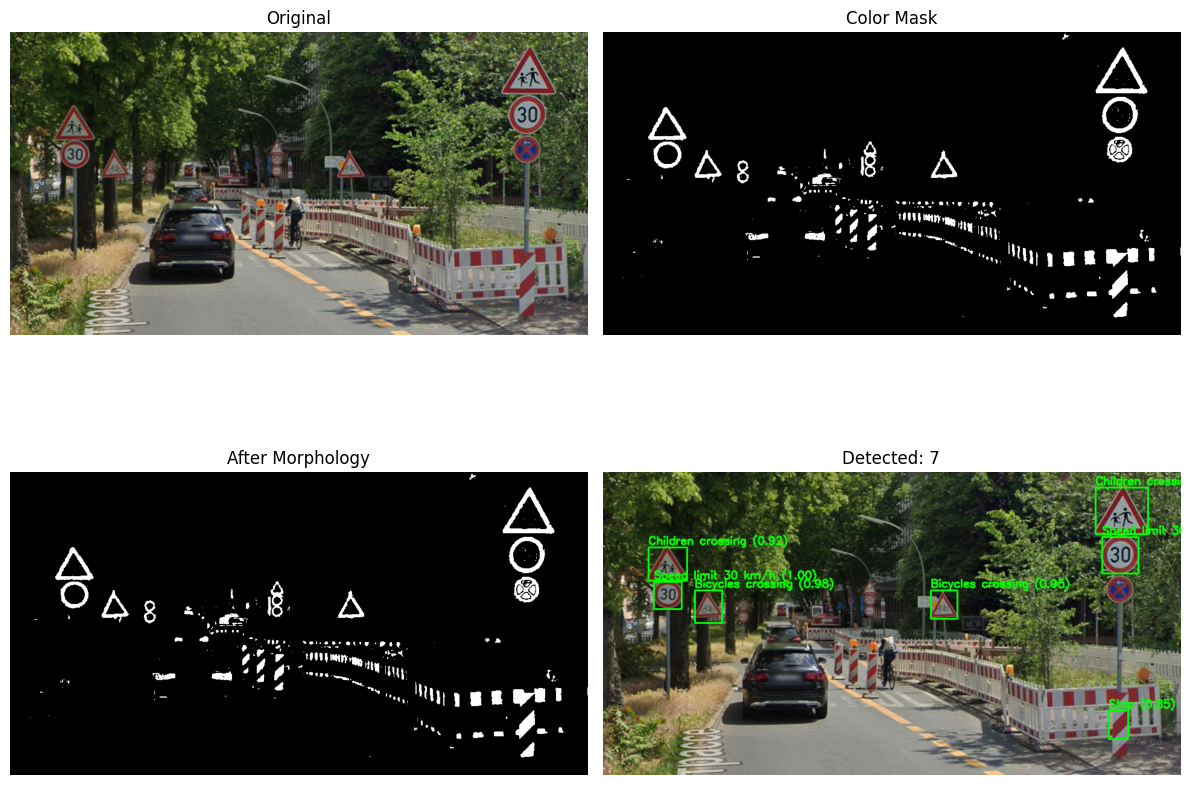

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN - Keep right  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
CNN - Yield  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
CNN - Yield  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN - Priority road  (conf=0.28)
--- 0.28233981132507324 seconds ---


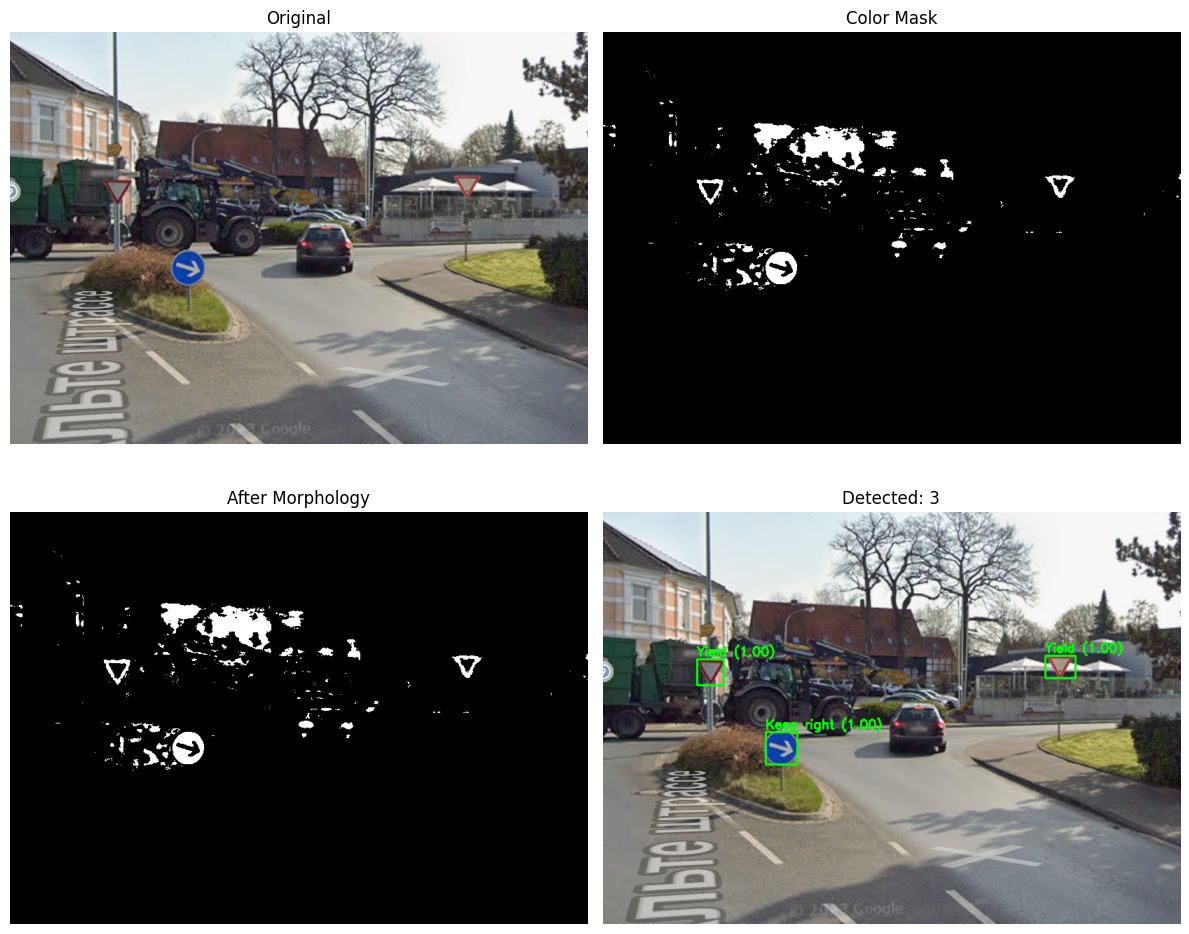

In [31]:
ref_features = build_gtsrb_reference("GTSRB/Train")
process_folder("images_real_maps", ref_features)

Loaded 0 reference sign samples from GTSRB
Processing 12 images from images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN - Speed limit 30 km/h  (conf=1.00)
--- 0.06998991966247559 seconds ---


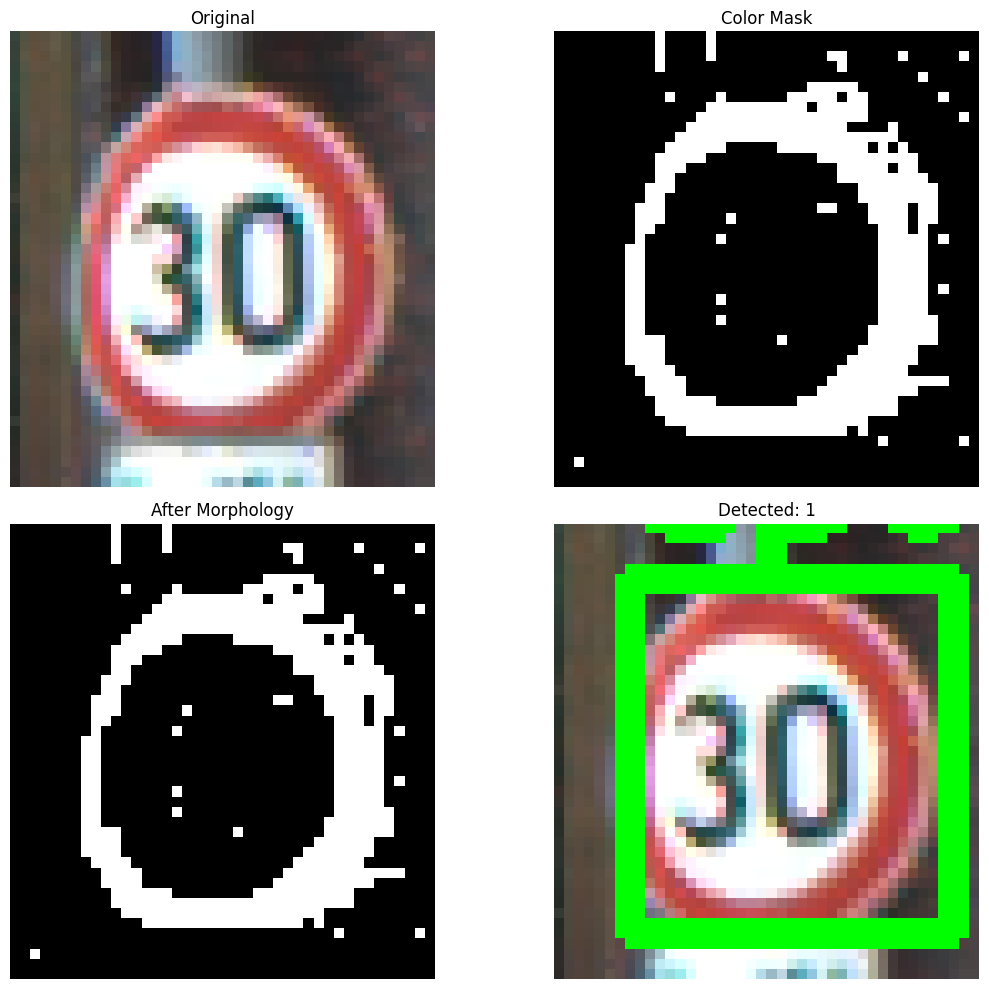

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN - Yield  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
CNN - Yield  (conf=1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN - No vehicles  (conf=0.58)
--- 0.20826244354248047 seconds ---


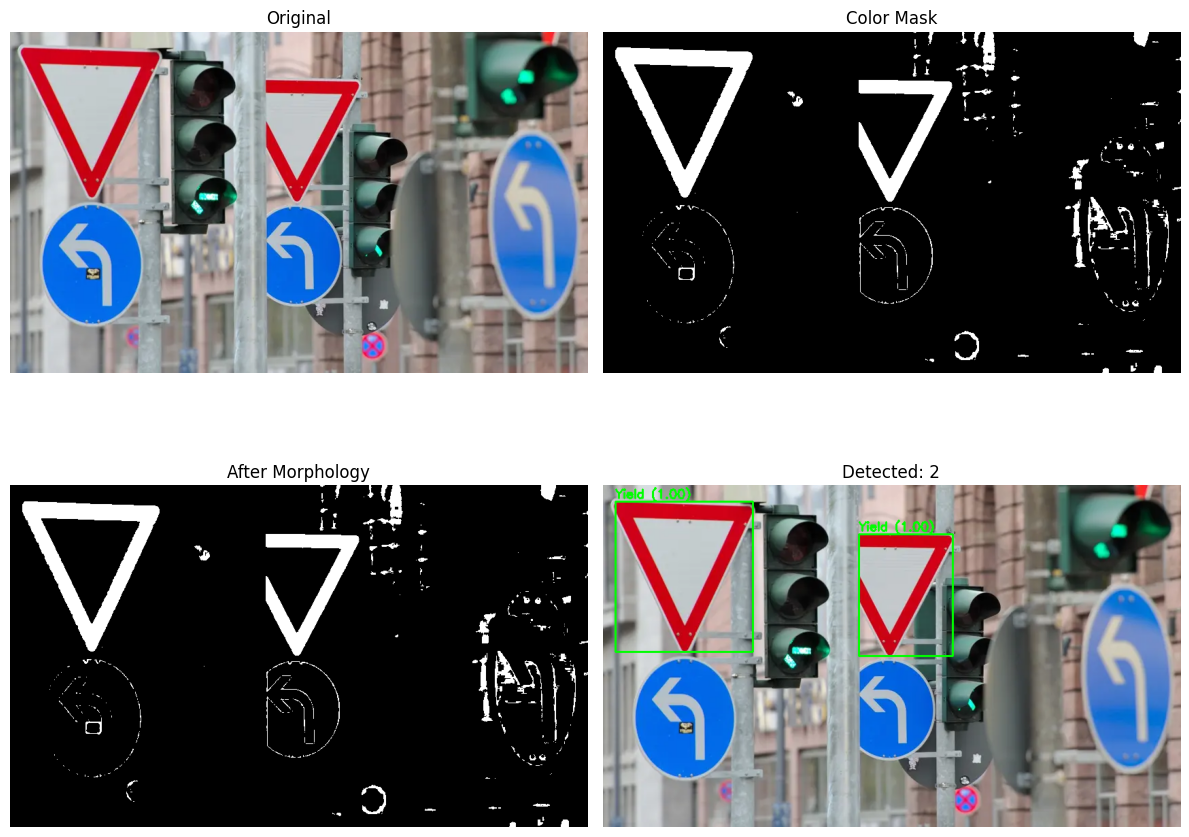

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
CNN - Speed limit 20 km/h  (conf=0.71)
--- 0.07876062393188477 seconds ---


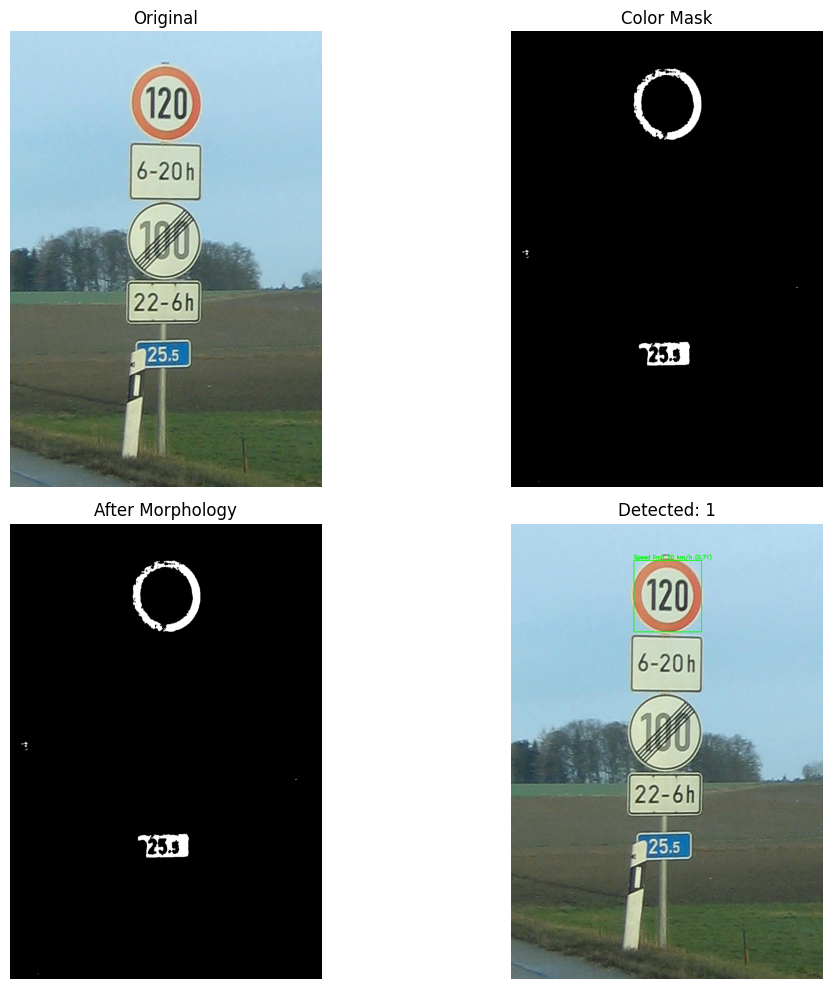

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
CNN - Yield  (conf=1.00)
--- 0.09287500381469727 seconds ---


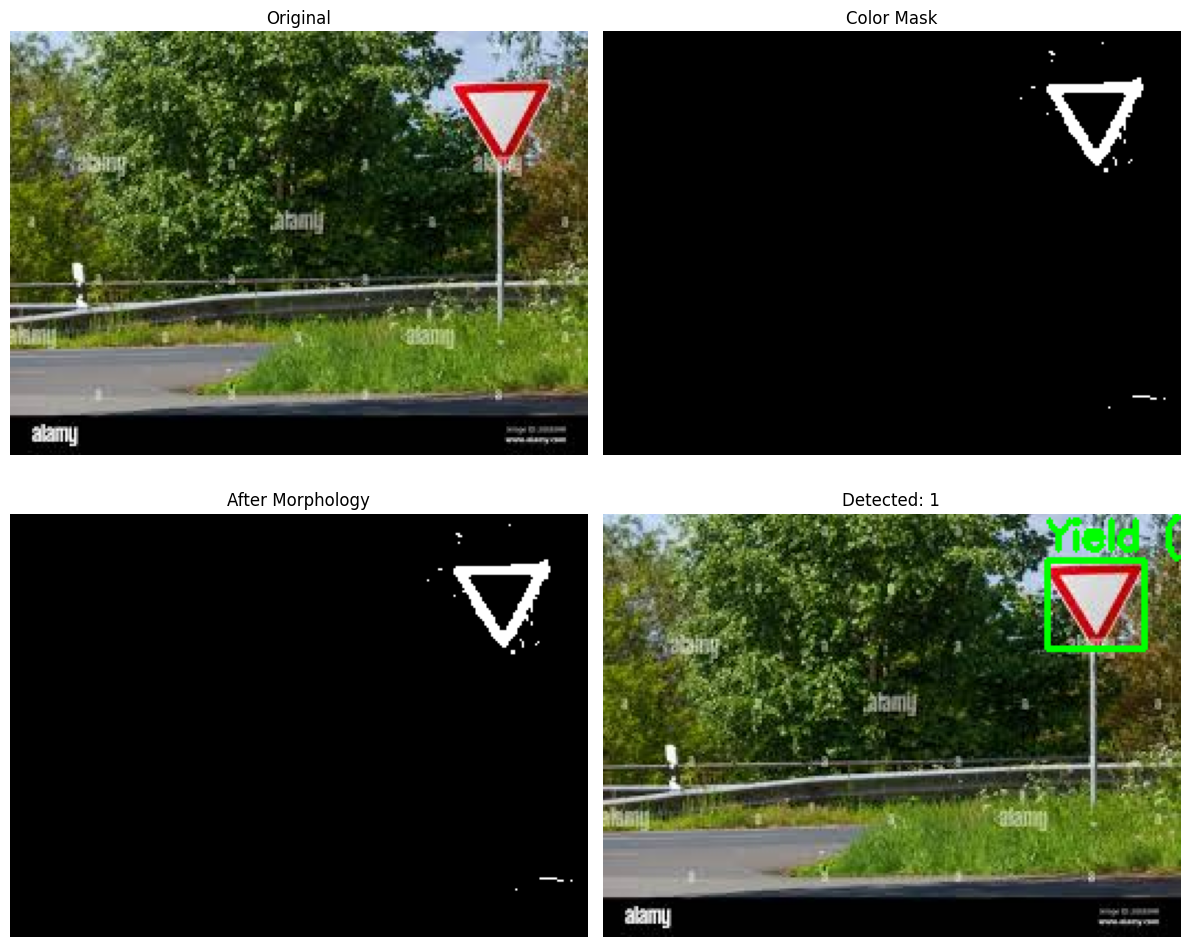

In [ ]:
ref_features = build_gtsrb_reference("GTSRB/Train")
process_folder("images", ref_features)